1. Data initialization

In [2]:
import os
import pandas as pd
import numpy as np
# from featurewiz import featurewiz
from matplotlib import pyplot as plt
import json


folder = os.path.join("/", "Data", "CREMEv2_Result", "20230310", "logs_working")

if os.path.exists(folder):
    print("Path is exist!!!")
    filename_label = 'relabel_syslog.csv'
    filename_ready = 'relabel_syslog_ready_technique.csv'
    filename_train = 'relabel_syslog_train_technique.csv'
    label_technique = 'labels_technique.json'
    label_lifecycle = 'labels_lifecycle.json'
else:
    print("Path is not exist!!!")

Path is exist!!!


2. Data processing and feature selection

In [ ]:
df = pd.read_csv(os.path.join(folder, filename_label), low_memory=False)
del_list = ['Timestamp', 'Label_lifecycle', 'HostName']
df.drop(columns=del_list, inplace=True)

# removing unused features from dataset
target = "Label"

feature, train = featurewiz(df, target, corr_limit=0.7, verbose=2, sep=",", header=0, test_data="", feature_engg="", category_encoders="")
df = train
print(feature)
output_filename = os.path.join(folder, filename_ready)
df.to_csv(output_filename, encoding='UTF-8', index=False)


3. Training preparation

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer

df = pd.read_csv(os.path.join(folder, filename_ready))


max_threshold = 100000
min_threshold = 10000

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))




for label in df['Label'].unique():
    # if too much, try drop duplicated first
    print(len(df[df['Label'] == label]))
    if len(df[df['Label'] == label]) > max_threshold:
        df_tmp = df.loc[df['Label'] == label].copy()
        df_tmp.drop_duplicates(keep='last', inplace=True)
        df.drop(df[df['Label'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])
        
    # if still too much, randomly picking some of them
    if len(df[df['Label'] == label]) > max_threshold:
        df_tmp = df.loc[df['Label'] == label].copy()
        df_tmp = df_tmp.sample(n=max_threshold, random_state=47)
        df.drop(df[df['Label'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])

    # if too few, double their number until it's enough
    while len(df[df['Label'] == label]) < min_threshold:
        tmp_df = df[df['Label'] == label]
        df = pd.concat([df, tmp_df])


# feature scaling
y_tmp = df['Label']
df.drop(columns=['Label'], inplace=True)
for feature in df.columns.values:
    scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
    df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
df = pd.concat([df, y_tmp], axis=1)


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, filename_train)
df.to_csv(output_file, encoding='utf-8', index=False)


4. Training and testing

In [3]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pickle
import time
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import math

models_folder = "model_syslog_100"

df = pd.read_csv(os.path.join(folder, "toTrain", filename_train))

#labelings map
label_origin = sorted([int(i) for i in df['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

X = df.drop(columns=['Label'])
X = X.to_numpy()
# X = X.reshape(-1)
y = df['Label']
y = y.to_numpy()
y = y.reshape(-1)
y = le.transform(y)

# print(np.unique(y))
# print(len(np.unique(y)))

#ML training
## Define ML model
core = -1

models = {}

### Linear models
models['Logistic_Regression'] = LogisticRegression(max_iter=1500, n_jobs=core)
models['SGD'] = SGDClassifier(n_jobs=core)
models['Passive_Aggressive'] = PassiveAggressiveClassifier(n_jobs=core)
### non-linear models
models['Decision_Tree'] = DecisionTreeClassifier()
models['Extra_Tree'] = ExtraTreeClassifier()
models['Naive_Bayes'] = GaussianNB()
# models['SVM'] = SVC(kernel='rbf', gamma='auto')
models['KNN'] = KNeighborsClassifier(n_jobs=core)
### ensemble models
models['Random_Forest'] = RandomForestClassifier(n_jobs=core)
# models['Ada_Boost'] = AdaBoostClassifier()
models['Bagging'] = BaggingClassifier(n_jobs=core)
models['Extra_Trees'] = ExtraTreesClassifier(n_jobs=core)
models['Gradient_Boosting'] = GradientBoostingClassifier()
models['XGBoost'] = XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core)


random_seed = 42


## training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, y_train = SMOTE(n_jobs=-1, random_state=random_seed).fit_resample(X_train, y_train)
print("original labels:{}".format(label_origin))
print("X_train:{}, y_train:{}".format(len(X_train), len(y_train)))


evaluation = {}
for name in models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
        # 'roc_auc_score': []
    }

    
for name, model in models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name)
    if os.path.exists(model_filename): # load the model from disk
        model = pickle.load(open(model_filename, 'rb'))
    else:
        model.fit(X_train, y_train)
        pickle.dump(model, open(model_filename, 'wb')) # save the model to disk
    y_hat = model.predict(X_test)
    end_time = time.time()
    print("model: {} \nexecution time: {:.2f}\n".format(name, end_time - start_time))
    
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='macro',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='macro', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='macro', zero_division=0))
    # evaluation[name]['roc_auc_score'].append(roc_auc_score(y, model.predict_proba(X)[:,1], multi_class='ovr'))

/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


original labels:[0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
X_train:937328, y_train:937328
model: Logistic_Regression 
execution time: 0.03

model: SGD 
execution time: 0.03

model: Passive_Aggressive 
execution time: 0.03

model: Decision_Tree 
execution time: 0.03

model: Extra_Tree 
execution time: 0.03

model: Naive_Bayes 
execution time: 1.14

model: KNN 
execution time: 77.84

model: Random_Forest 
execution time: 1.62

model: Bagging 
execution time: 3.75

model: Extra_Trees 
execution time: 1.70

model: Gradient_Boosting 
execution time: 8.17

model: XGBoost 
execution time: 0.31



Visualization

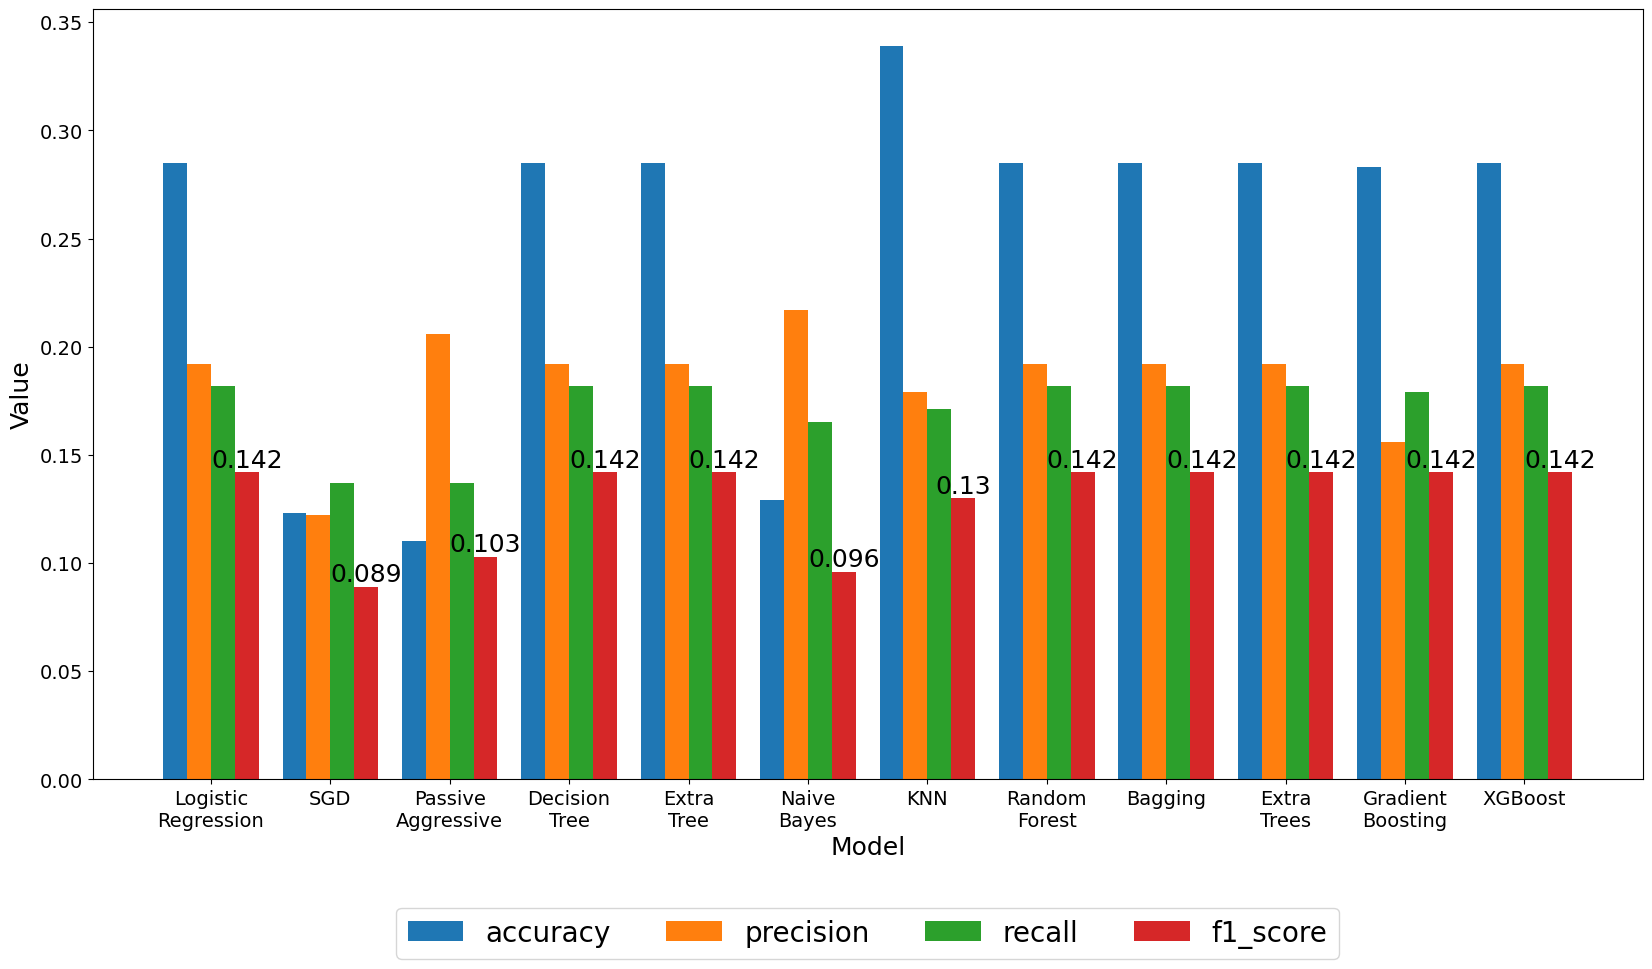

In [5]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

data_type = 'Syslog'

def rounded(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(rounded(mean(value), 3))
        
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=18)
# plt.title('Technique Model Evaluation for '+data_type, fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('Model', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})
plt.legend(loc='center', fontsize=20, ncol=4, bbox_to_anchor=(0.5,-0.2))
plt.show()




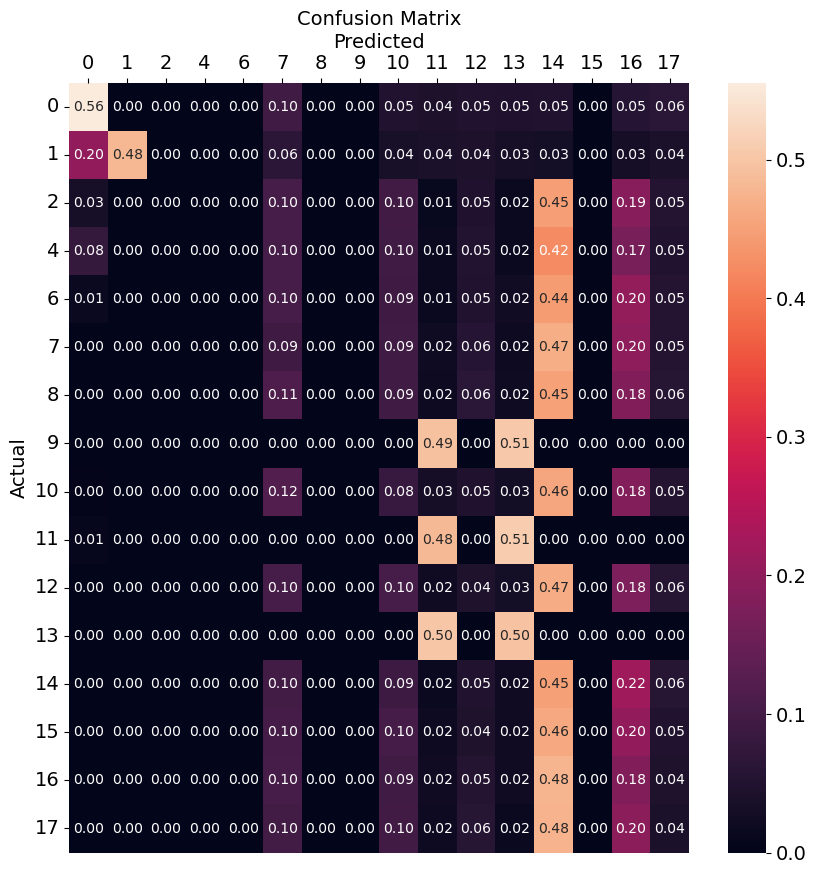

In [58]:

name = 'Bagging'
model_filename = os.path.join(models_folder, name)
title = "Technique Confusion Matrix of {}".format(data_type)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = label_origin
# model = tf.keras.models.load_model(model_filename)
model = pickle.load(open(model_filename, 'rb'))
y_hat = model.predict(X_test)
# y_hat = np.argmax(y_hat, axis=1)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title(title, fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)

In [6]:
import json

with open(os.path.join(models_folder, 'evaluation result.json'), 'w') as file:
    file.write(json.dumps(evaluation))
print(evaluation)

{'Logistic_Regression': {'accuracy': [0.2852352018462759], 'precision': [0.19276024929259158], 'recall': [0.18275325590492414], 'f1_score': [0.14216723148331714]}, 'SGD': {'accuracy': [0.12372212105367543], 'precision': [0.12210425971064444], 'recall': [0.13754643733124738], 'f1_score': [0.08988335361040495]}, 'Passive_Aggressive': {'accuracy': [0.11068640354831148], 'precision': [0.2061660113153266], 'recall': [0.13766631577888697], 'f1_score': [0.10330926802347407]}, 'Decision_Tree': {'accuracy': [0.2852352018462759], 'precision': [0.19276024929259158], 'recall': [0.18275325590492414], 'f1_score': [0.14216723148331714]}, 'Extra_Tree': {'accuracy': [0.2852352018462759], 'precision': [0.19276024929259158], 'recall': [0.18275325590492414], 'f1_score': [0.14216723148331714]}, 'Naive_Bayes': {'accuracy': [0.129059012314516], 'precision': [0.21763051160632924], 'recall': [0.16580461188558382], 'f1_score': [0.09633223793293569]}, 'KNN': {'accuracy': [0.33964985666119757], 'precision': [0.17

Training with original feature selection

In [33]:
from sklearn.feature_selection import VarianceThreshold

drop_cols = ['Timestamp', 'Label_lifecycle', 'HostName']
df = pd.read_csv(os.path.join(folder, filename_label), low_memory=False)
df = df.drop(columns=drop_cols)
corr_threshold = 0.9

# removing unused features from dataset
y_tmp = df['Label']
# delete features with all the same value
df.drop('Label', axis=1, inplace=True)
selector = VarianceThreshold(threshold=0)
selector.fit(df)
print(selector.variances_)
constant_columns = [column for column in df.columns
                    if column not in 
                    df.columns[selector.get_support()]]
df.drop(labels=constant_columns, axis=1, inplace=True)

# delete similar features
df_tmp = df
corr_features = set()
corr_matrix = df_tmp.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
df.drop(labels=corr_features, axis=1, inplace=True)


output_filename = os.path.join(folder, "origin_"+filename_ready)
df.to_csv(output_filename, encoding='UTF-8', index=False)

[4.23795256e-06 4.23795256e-06 2.84547290e-02 1.86671930e-01
 1.69490084e-04 4.23795256e-06 4.23795256e-06 2.16089782e-04
 4.87129084e-04 4.23779092e-05 6.35655167e-05 4.23795256e-06
 4.23779092e-05 6.35655167e-05 8.47586920e-06 2.11894036e-05
 2.11894036e-05 3.81402799e-05 1.75988758e-03 2.11894036e-05
 1.67541985e-03 2.11894036e-05 4.23795256e-06 4.23779092e-05
 1.27137499e-05 5.15488978e-02 2.11894036e-05 3.26217243e-04
 4.23795256e-06 8.47586920e-06 4.23795256e-06 8.95787691e-03
 1.08074393e-01 1.08074393e-01 8.95787691e-03 1.52543662e-04
 8.47586920e-06 4.23779092e-05 1.24135958e-01 6.72211208e-02
 4.23779092e-05 1.08032879e-01 1.69515947e-05 8.47586920e-06
 1.18649094e-04 1.05938038e-04 1.05938038e-04 1.05938038e-04
 1.67541985e-03 1.27137499e-05 3.81402799e-05 2.96649136e-05
 1.52543662e-04 8.47522263e-05 5.14733736e-02 1.27137499e-05
 2.54271765e-05]


In [36]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer

df = pd.read_csv(os.path.join(folder, filename_ready))

max_threshold = 50000
min_threshold = 5000

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))


for label in df['Label'].unique():
    # if too much, try drop duplicated first
    print(len(df[df['Label'] == label]))
    if len(df[df['Label'] == label]) > max_threshold:
        df_tmp = df.loc[df['Label'] == label].copy()
        df_tmp.drop_duplicates(keep='last', inplace=True)
        df.drop(df[df['Label'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])
        
    # if still too much, randomly picking some of them
    if len(df[df['Label'] == label]) > max_threshold:
        df_tmp = df.loc[df['Label'] == label].copy()
        df_tmp = df_tmp.sample(n=max_threshold, random_state=47)
        df.drop(df[df['Label'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])

    # if too few, double their number until it's enough
    while len(df[df['Label'] == label]) < min_threshold:
        tmp_df = df[df['Label'] == label]
        df = pd.concat([df, tmp_df])


# feature scaling
y_tmp = df['Label']
df.drop(columns=['Label'], inplace=True)
for feature in df.columns.values:
    scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
    df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
df = pd.concat([df, y_tmp], axis=1)


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, "origin_"+filename_train)
df.to_csv(output_file, encoding='utf-8', index=False)

origin data number: 235962
origin features: 40
73120
116844
6
378
441
7925
8251
5052
5594
2224
1652
3398
2757
2771
1690
3859
remain data number: 137269
remain features: 40


In [38]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pickle
import time
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import math

models_folder = "model_syslog_orig"

df = pd.read_csv(os.path.join(folder, "origin_"+filename_train))

#labelings map
label_origin = sorted([int(i) for i in df['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

X = df.drop(columns=['Label'])
X = X.to_numpy()
# X = X.reshape(-1)
y = df['Label']
y = y.to_numpy()
y = y.reshape(-1)
y = le.transform(y)


#ML training
## Define ML model
core = -1

models = {}

### Linear models
models['Logistic_Regression'] = LogisticRegression(max_iter=1500, n_jobs=core)
models['SGD'] = SGDClassifier(n_jobs=core)
models['Passive_Aggressive'] = PassiveAggressiveClassifier(n_jobs=core)
### non-linear models
models['Decision_Tree'] = DecisionTreeClassifier()
models['Extra_Tree'] = ExtraTreeClassifier()
models['Naive_Bayes'] = GaussianNB()
models['SVM'] = SVC(kernel='rbf', gamma='auto')
models['KNN'] = KNeighborsClassifier(n_jobs=core)
### ensemble models
models['Random_Forest'] = RandomForestClassifier(n_jobs=core)
models['Ada_Boost'] = AdaBoostClassifier()
models['Bagging'] = BaggingClassifier(n_jobs=core)
models['Extra_Trees'] = ExtraTreesClassifier(n_jobs=core)
models['Gradient_Boosting'] = GradientBoostingClassifier()
models['XGBoost'] = XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core)


random_seed = 42


## training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, y_train = SMOTE(n_jobs=-1, random_state=random_seed).fit_resample(X_train, y_train)
print("original labels:{}".format(label_origin))
print("X_train:{}, y_train:{}".format(len(X_train), len(y_train)))


evaluation = {}
for name in models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
        # 'roc_auc_score': []
    }

    
for name, model in models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name)
    if os.path.exists(model_filename): # load the model from disk
        model = pickle.load(open(model_filename, 'rb'))
    else:
        model.fit(X_train, y_train)
        pickle.dump(model, open(model_filename, 'wb')) # save the model to disk
    y_hat = model.predict(X_test)
    end_time = time.time()
    print("model: {} \nexecution time: {:.2f}\n".format(name, end_time - start_time))
    
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='macro',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='macro', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='macro', zero_division=0))
    # evaluation[name]['roc_auc_score'].append(roc_auc_score(y, model.predict_proba(X)[:,1], multi_class='ovr'))

KeyboardInterrupt: 

In [ ]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

data_type = 'Syslog'

def rounded(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(rounded(mean(value), 3))
        
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.title('Model Evaluation for '+data_type, fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('model', fontsize=25)
plt.ylabel('value', fontsize=22)
plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 20,
})
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)
plt.show()

In [ ]:
name = 'XGBoost'
model_filename = os.path.join(models_folder, name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = label_origin
# model = tf.keras.models.load_model(model_filename)
model = pickle.load(open(model_filename, 'rb'))
y_hat = model.predict(X_test)
# y_hat = np.argmax(y_hat, axis=1)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)